# Data loading with the GDS Python client

This notebook covers method for loading data into a Neo4j database instance with the Neo4j Graph Data Science (GDS) library installed, in order to do analytics on this data.

We will cover methods for:
* Loading existing example datasets built into the `graphdatascience` library, and
* Importing graph data that is not yet stored in a Neo4j database.

## Setup

Let's start by installing the `graphdatascience` library, with its extra dependencies, we need.

In [ ]:
%pip install "graphdatascience[ogb, networkx]"

Now we can continue to set up our connectiong to the Neo4j database.

In [1]:
from graphdatascience import GraphDataScience

gds = GraphDataScience("bolt://localhost:7687")  # Replace URI with any of your choice

## Built-in example datasets

The `graphdatascience` library comes with a bunch of built-in datasets which one can load into to GDS with a single Python method call.

### Pre-canned datasets

These are smaller datasets built into the `graphdatascience` library artifact, which means that one can load them even without internet access.

Let's look at an example where we load the IMDB dataset from the "Graph Transformer Networks" [0] paper. As promised, we only have to make one call to do this:

In [70]:
G = gds.graph.load_imdb()

TransientError: {code: Neo.TransientError.General.OutOfMemoryError} {message: There is not enough memory to perform the current task. Please try increasing 'server.memory.heap.max_size' in the neo4j configuration (normally in 'conf/neo4j.conf' or, if you are using Neo4j Desktop, found through the user interface) or if you are running an embedded installation increase the heap by using '-Xmx' command line flag, and then restart the database.}

Now let's inspect the graph we have product, by called convenience methods on the `Graph` object which represents it.

In [ ]:
print(f"Node count: {G.node_count()}")
print(f"Relationship count: {G.relationship_count()}")
print(f"Node labels: {G.node_labels()}")
print(f"Relationship types: {G.relationship_types()}")

The `UnclassifiedMovie` node label represents movie nodes that are not yet assigned a genre.
The node classification task is to make this assignment based on the rest of the information in the graph.

Finally, let's clean up to clear up some memory on our machine.

In [71]:
G.drop()

Failed to read from defunct connection IPv4Address(('localhost', 7687)) (ResolvedIPv4Address(('127.0.0.1', 7687)))
Unable to connect to the Neo4j DBMS. Trying again...
Unable to connect to the Neo4j DBMS. Trying again...


KeyboardInterrupt: 

### Open Graph Benchmark

The Open Graph Benchmark (OGB) is a collection of realistic, large-scale, and diverse benchmark datasets for machine learning on graphs. The `graphdatascience` supports conveniently loading these.

Let's look at an example of loading the homogeneous academic citation network graph `ogbn-arxiv`. It's used in the academic literature to benchmark the quality of node classification algorithms.

In [69]:
G = gds.graph.ogbn.load("ogbn-arxiv")

ModuleNotFoundError: This feature requires OGB support. You can add OGB support by running `pip install graphdatascience[ogb]`

Now let's inspect the graph we have product, by called convenience methods on the `Graph` object which represents it.

In [ ]:
print(f"Node count: {G.node_count()}")
print(f"Relationship count: {G.relationship_count()}")
print(f"Node labels: {G.node_labels()}")
print(f"Properties on TRAIN nodes: {G.node_properties()['Train']}")

There are really only "paper" nodes and "cites" relationships, but here we see three node labels nevertheless.
These node labels represent the node dataset split, which is useful if one were to do train some machine learning model on the data, and compare it to other algorithms in the [benchmark](https://ogb.stanford.edu/docs/leader_nodeprop/#ogbn-arxiv).
For example, we could use a [GDS node classification pipeline](https://neo4j.com/docs/graph-data-science-client/current/pipelines/#_node_classification) to solve this problem.

Finally, let's clean up to clear up some memory on our machine.

In [ ]:
G.drop()

## Loading formats

If you have your own data, but not in a Neo4j database, you can import it into GDS and Neo4j from various formats using `graphdatascience`.

### Pandas DataFrames

The format most native to the `graphdatascience` library, is the `pandas.DataFrame` format.
It's an intuitive way of describing entity properties and connectivty as columns in a `pandas.DataFrame`.

The API for this is perhaps best understood by checking out a small example, so let's do that. For more details, have a look at [the documentation](https://neo4j.com/docs/graph-data-science-client/current/graph-object/#construct).

In this small toy example, we create a graph with four people represented by nodes, at a small office. Two of them are coworkers, and there's a manager for one of the employees. The `WORKS_WITH` relationship type is loaded as `UNDIRECTED` since it's a mutual relationship.

In [7]:
import pandas

nodes = pandas.DataFrame(
    {
        "nodeId": [0, 1, 2, 3],
        "labels": ["Employee", "Employee", "Employee", "Manager"],
        "yearsAtJob": [19, 2, 4, 1],  # Node property
    }
)

relationships = pandas.DataFrame(
    {
        "sourceNodeId": [0, 3],
        "targetNodeId": [1, 2],
        "relationshipType": ["WORKS_WITH", "MANAGES"],
    }
)

G = gds.graph.construct(
    "small-office", nodes, relationships, undirected_relationship_types=["WORKS_WITH"]
)

ValueError: Graph 'my-graph' already exists. Please drop the existing graph or use a different name.

Once again, we can sanity check our graph projection.

In [78]:
print(f"Node count: {G.node_count()}")
print(f"Relationship count: {G.relationship_count()}")
print(f"Node labels: {G.node_labels()}")
print(f"Relationship types: {G.relationship_types()}")

ValueError: There is no projected graph named 'communities'

It looks right! Finally, let's clean up to clear up some memory on our machine.

In [14]:
G.drop()

,graphName,database,memoryUsage,sizeInBytes,nodeCount,relationshipCount,configuration,density,creationTime,modificationTime,schema,schemaWithOrientation


### NetworkX

[NetworkX](https://networkx.org/) is a Python package for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks.

NetworkX has great operability with other libraries in the Python ecosystem, and has great support for:
* [Reading graph files](https://networkx.org/documentation/stable/reference/readwrite/index.html) of various formats, and
* [Generating graphs](https://networkx.org/documentation/stable/reference/generators.html) of various types popular in the academic literature

For these reasons, we recently added NetworkX graph importing to `graphdatascience`. To understand these capabilities, we will once again look at an example.
For more details, please have a look at [the documentation](https://neo4j.com/docs/graph-data-science-client/current/graph-object/#networkx) where the API is described in detail.

In this example we will:
1. Generate a graph using the [Stochastic block model method (SBS)](https://en.wikipedia.org/wiki/Stochastic_block_model) capabilities of NetworkX
2. Plot the NetworkX graph
3. Import the NetworkX graph into Neo4j GDS
4. Run the Louvain algorithm in GDS and stream back the results
5. Plot the algorithm results on the NetworkX graph

So we start by generating a NetworkX graph with 200 nodes divided into three blocks.
The idea of SBS is that these blocks will represent communities in the graph, with each block being more densely connected within itself than with other blocks.
Exactly how dense can be configured with the `edge_probabilities` parameter below.

In [52]:
import networkx as nx

block_sizes = [50, 50, 100]
edge_probabilities = [[0.25, 0.05, 0.02], [0.05, 0.35, 0.07], [0.02, 0.07, 0.40]]
nx_G = nx.stochastic_block_model(block_sizes, edge_probabilities, seed=0)

Let's now have a look at the graph we generated by plotting it.

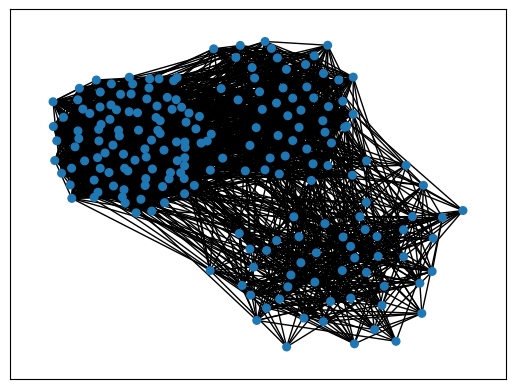

In [75]:
nx.draw_networkx(nx_G, node_size=[30] * 200, with_labels=False)

Indeed, it kind looks like there are three communities.
But it would be better to be sure, for example by letting the Louvain algorithm analyze the graph.
To do that, let's import the NetworkX graph `nx_G` into Neo4j GDS.

In [62]:
G = gds.graph.networkx.load(nx_G, "communities")

ClientError: {code: Neo.ClientError.Procedure.ProcedureCallFailed} {message: Failed to invoke function `gds.graph.project`: Caused by: java.lang.IllegalArgumentException: Graph communities already exists}

Now that we have our graph in GDS land, we can run a highly optimized implementation of Louvain on our graph.

In [79]:
result = gds.louvain.stream(G)
print(result)

ClientError: {code: Neo.ClientError.Procedure.ProcedureCallFailed} {message: Failed to invoke procedure `gds.louvain.stream`: Caused by: java.util.NoSuchElementException: Graph with name `communities` does not exist on database `neo4j`. It might exist on another database.}

In [59]:
from random import random, seed

seed(2)  # To make color generated deterministic

cid_to_color = {
    cid: (random(), random(), random()) for cid in result["communityId"].unique()
}

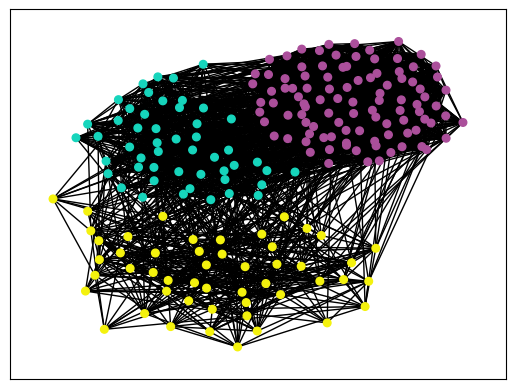

In [76]:
node_colors = [cid_to_color[cid] for cid in result["communityId"]]

nx.draw_networkx(nx_G, node_size=[30] * 200, with_labels=False, node_color=node_colors)

This was a homogeneous example and without any properties.
Please note however, that `gds.graph.networkx.load` is fully capable of handling heterogeneity and properties as well.

## References

* [0]: 